# Cleaning University of California Berkeley Power Consumption Dataset

The data retrieved from [UCB's energy dashboard](https://engagementdashboard.com/ucb/ucb) regarding power consumption in UCB's Mechanical Engineering building is in the form of a `json` format. Here we'll be converting it into a `csv` file for later data analysis. 

In [185]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import pprint
import requests
from datetime import datetime

In [186]:
#Format into dates
def format_time(unix_timestamp):
    format = '%Y-%m-%d'
    ts = int(unix_timestamp)
    return datetime.utcfromtimestamp(ts).strftime(format)

#Create list of datetime objects from timestamps
def gen_datetimes(li):
    datetimes = []
    for time in li:
        datetimes.append(datetime.utcfromtimestamp(time))
    return datetimes

#Get day of week based on date
def get_weekday(dates):
    return [1 if (datetime.strptime(d,"%Y-%m-%d").weekday() >= 5) else 0 for d in dates]

In [187]:
#Making requests
def make_request(location_id):
    #NOTE: Make sure the start and end time are exactly the same as current date.
    endTime = "2020-11-21"
    startTime = "2019-11-21"
    url = "https://engagementdashboard.com/a/consumption?endTime=" + endTime + "T19:59:59.000Z&granularity=DAY&locationIds=" + str(location_id) + "&resource=Electricity&startTime="+ startTime + "T20:00:00.000Z"
    payload = {}
    headers = {}
    response = requests.request("GET", url, headers=headers, data = payload)
    return response.json()

In [188]:
#Parse JSON string into dataframe for power
def parse_json(json_string):
    data = json_string[0]
    
    #Split dataset
    actual = data['actual']
    
    #Create new dataframe
    df_power = pd.DataFrame(columns = ['act_power', 'date', 'timestamp'])
    df_power.head()
    
    actual_li = actual['data']
    loc = 0

    for i in range(len(actual_li)):
        #Get corresponding dicts
        dt1 = actual_li[i]

        #Get data in appropriate format
        time = format_time(dt1['timestamp'])
        act_power = dt1['value']
        ts = dt1['timestamp']

        #Add to dataframe
        df_power.loc[loc] = [act_power, time, ts]

        #Increment location tracker
        loc += 1

    #Add Weekdays 
    df_power['Weekday'] = get_weekday(df_power['date'])
    
    return df_power

In [189]:
#Merge weather data and power data 
def merge_weather(df_power, weather_data='Datasets/Berkeley_Weather.csv'):
    #Read data, drop unused columns and remove 0 values
    df_weather = pd.read_csv('Datasets/Berkeley_Weather.csv', skiprows=2)
    df_weather = df_weather.drop(columns=['Hour', 'Minute'])
    df_weather = df_weather[df_weather.DNI != 0]

    #Take mean, max and min for each DNI in DataFrame and mean for everything else
    max_dni = df_weather.groupby(['Year', 'Month', 'Day']).max().reset_index()['DNI']
    min_dni = df_weather.groupby(['Year', 'Month', 'Day']).min().reset_index()['DNI']
    df_weather = pd.DataFrame(df_weather.groupby(['Year', 'Month', 'Day']).mean().reset_index())
    df_weather.insert(4, 'DNI Max', max_dni)
    df_weather.insert(5, 'DNI Min', min_dni)
    
    #Split into Y M and D
    df_power[['Year', 'Month', 'Day']] = df_power.date.str.split('-', expand=True).apply(pd.to_numeric)

    #Merge data together
    df_merge = df_weather.merge(df_power[['act_power', 'Month', 'Day', 'Weekday']], left_on=('Month', 'Day'), right_on=('Month', 'Day'), how = 'inner', suffixes=('_left','_right'))
    df_merge = df_merge.rename(columns={'act_power': 'Power Consumption', 'DNI':'DNI Mean'})
    df_merge = df_merge.drop(columns=['Dew Point'])
    
    return df_merge

In [190]:
#Simplified lambda expression for doing all three steps at once.
gen_data = lambda building_id : merge_weather(parse_json(make_request(building_id)))

In [191]:
#List of datapoints we're interested in.
data = pd.read_csv("Datasets/UCB_Keys.csv")
data.head()

,Key,University Name,Building Name,Square Feet,Type
0,257,"University of California, Berkeley",Etcheverry Hall,179722,Laboratory
1,216,"University of California, Berkeley",Energy Biosciences Building,124175,Laboratory
2,275,"University of California, Berkeley",Lawrence Hall of Science,131464,Facility
3,208,"University of California, Berkeley",Hesse Hall,41444,Office
4,249,"University of California, Berkeley",Davis Hall,140090,Laboratory


In [192]:
#Add all rows to common DataFrame, with diffrentiating factors included

df = pd.DataFrame()

for i in range(0, len(data)):
    print(str(i + 1) + ", ", end = '')
    current_df = gen_data(data['Key'][i])
    current_df['University Name'] = data['University Name'][i]
    current_df['Building Name'] = data['Building Name'][i]
    current_df['Square Feet'] = data['Square Feet'][i]
    current_df['Type'] = data['Type'][i]
    df = df.append(current_df)
    
df.head()

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 

,Year,Month,Day,DNI Mean,DNI Max,DNI Min,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,Power Consumption,Weekday,University Name,Building Name,Square Feet,Type
0,2019,1,1,722.400000,952,45,2.120000,0.555000,47.75,43.414000,8.555,1004.55,7888.0,0,"University of California, Berkeley",Etcheverry Hall,179722,Laboratory
1,2019,1,2,714.100000,925,67,1.465000,1.000000,66.05,57.277500,9.150,1004.40,8323.0,0,"University of California, Berkeley",Etcheverry Hall,179722,Laboratory
2,2019,1,3,480.100000,899,14,2.040000,0.975000,75.85,64.874500,8.680,1001.75,8468.0,0,"University of California, Berkeley",Etcheverry Hall,179722,Laboratory
3,2019,1,4,579.950000,912,30,1.675000,0.985000,111.30,73.464000,9.970,994.65,8177.0,1,"University of California, Berkeley",Etcheverry Hall,179722,Laboratory
4,2019,1,5,25.388889,93,1,6.194444,1.955556,182.50,90.365556,11.500,985.00,8188.0,1,"University of California, Berkeley",Etcheverry Hall,179722,Laboratory


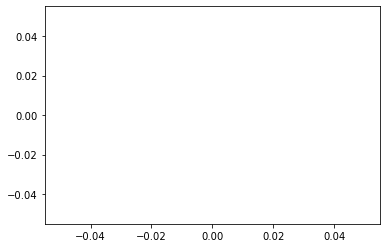

In [193]:
#Exploratory Analysis between Square Feet and Power Consumption
import matplotlib.pyplot as plt

df1 = df[df['Square Feet'] == 421939]
plt.scatter(df1['Square Feet'], df1['Power Consumption'], c = df1['Square Feet'])

#plt.scatter(df['Square Feet'], df['Power Consumption'], c = df['Square Feet'])
plt.show()

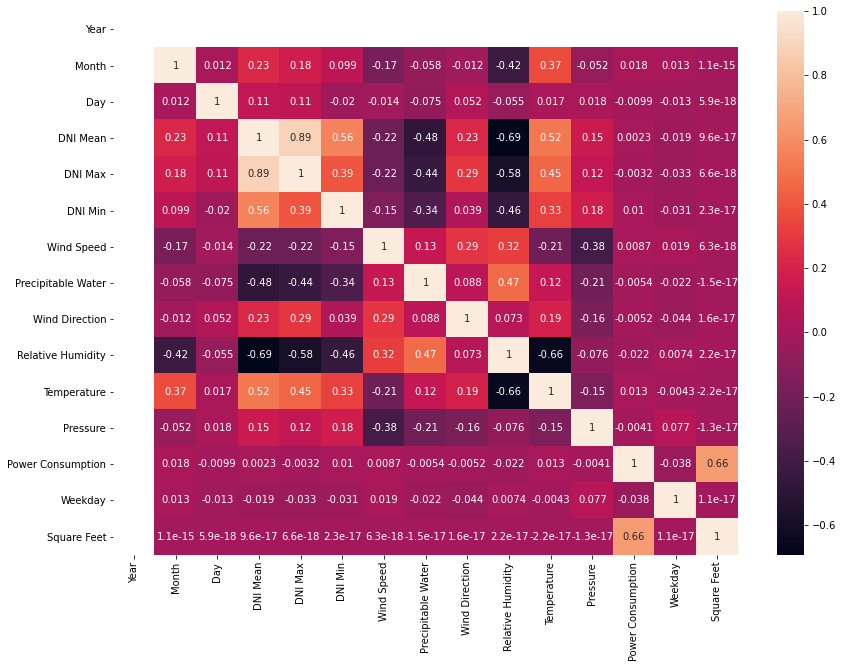

In [194]:
#Heatmap for whole dataset
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

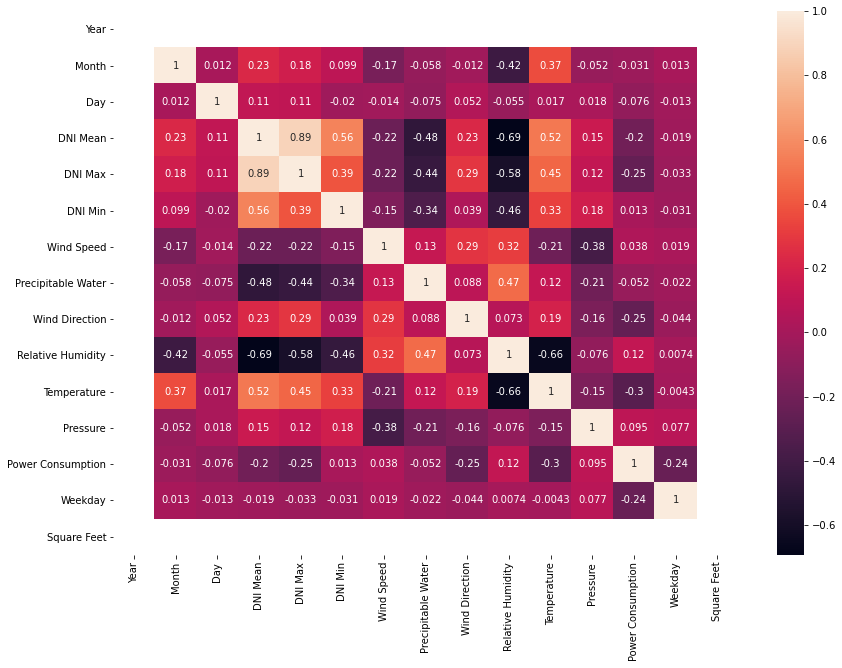

In [195]:
#Analysis of a single building's data
df1 = df[df['Building Name'] == "Etcheverry Hall"]
plt.figure(figsize=(14,10))
sns.heatmap(df1.corr(), annot=True)
plt.show()

In [196]:
#Saving data to file
df.to_csv('Datasets/UCB_PowerWeatherData.csv', index=False)